## Прогнозирование выживших пассажиров Титаника. 
В качестве данных взят датасет с платформы Kaggleimport pandas as pd


Для начала подгрузим минимальный набор библиотек, которые точно потребуются (лишними они никогда не бывают). 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as cp

import matplotlib.pyplot as plt
import seaborn as sns

## Анализ даных

In [2]:
df_titanic = pd.read_csv("train.csv")

In [3]:
df_titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Первое, что бросается в глаза это колонка PassengerId, которая идентифицирует каждую строку датасета (каждого пассажира). Следовательно стоит ее использовать как индекс датафрейма

In [4]:
df_titanic.index = df_titanic.PassengerId
df_titanic=df_titanic.drop("PassengerId",axis=1)


In [5]:
df_titanic.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Посмотрим на размер данных
# имеем 891 объект и 11 признаков
df_titanic.shape

(891, 11)

Посмотрим на струтуру данных:
1. Survived - целевая переменная (1-пассажир выжил, 0-пассажир не выжил)
2. Pclass - класс билета. (1-й 2-й 3-й) 
3. Name - имя пасссажира.
4. Sex - пол пассажира.
5. Age - возрас пассажира.
6. Sibsp - признак, выражающий количество братьев, сестер, супругов пассажира на борту.
7. Parch - признак, выражающий количество детей, родителей на борту.
8. Ticket - номер билета.
9. Fare - пассажирский тариф.
10. Cabin - номер кабины.
11. Embarked - порт погрузки (C = Шербур, Q = Квинстаун, S = Саутгемптон)

А что хранится в этих признаках

In [7]:
df_titanic.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

Видно, что признаки Pclass, Age, SibSp, Parch, Fare выражены числами, стоит взглянуть на то какие значения они могут принимать. Для этого можно построить гистограммы распределения признаков.


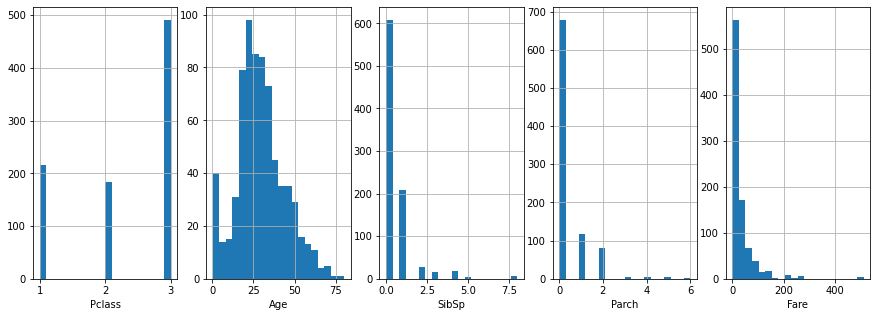

In [8]:
fig, axs = plt.subplots(1,5, figsize=(15,5))
features = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
for feature, ax in zip(features, axs):
    df_titanic[feature].hist(bins=20,ax=ax)
    ax.set_xlabel(feature)


Иследуя диаграммы можно разделить признаки на:
1. количественные: Age, SibSp, Parch, Fare (кроме того Age, Fare - непрерывные; Sib, Parch - дискретные)
2. качественные: Pclass (так как из условия нам известно, что это номер класса, то этот признак порядковый)

Исследуем другие признаки

In [9]:
# Признак Name содержит имна пассажиров. с первого взгляда сложно понять как его использовать для прогнозирования.
# Возможно стоит преобразовать этот признак в другое представление
df_titanic.Name.value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

In [10]:
# Признак Sex является бинарым его будет удобно представить двумя двоичными векторами-индикаторами
df_titanic.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [11]:
# Признак Ticket кажется обсалютно случайным. Врядли его получится разумно учесть в предсказании.
df_titanic.Ticket

PassengerId
1             A/5 21171
2              PC 17599
3      STON/O2. 3101282
4                113803
5                373450
             ...       
887              211536
888              112053
889          W./C. 6607
890              111369
891              370376
Name: Ticket, Length: 891, dtype: object

In [12]:
# Признак Cabin выглядит более полезным чем признак Ticket 
# возможно его удастся преобразовать в другой вид для использования
df_titanic.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [13]:
# Признак Embarked является качественным, номинальным, его будет удобно закодировать 
# в виде двух столбцов-индикаторов (S,C) 0 в обоих столбцах будет указывать на порт Q. 
df_titanic.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Когда все данные разобраны можно приступить к поиску и устранению пропусков, если они имеются.

In [14]:
# Видно, что в данных имеются пропуски в признаках Age, Cabin, Embarked
# при этом из 891 у 687 не известен номер кабины. Стоит обратить внимание на пассажиров
# с известным номером кабины. Возможно имеет смысл удалить этот признак.
# Признак Age удалять скорее всего не целесообразно (будем исследовать дальше).
# Признак Embarked имеет пропуски всегт у 2 пассажиров. 
# Возможно имеет сымл просто убрать этих пассажиров из рассмотрения.
df_titanic.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Количество выживших пассажиров: 342
Количество невыживших пассажиров: 549
Соотношение между группами: 37.704918032786885


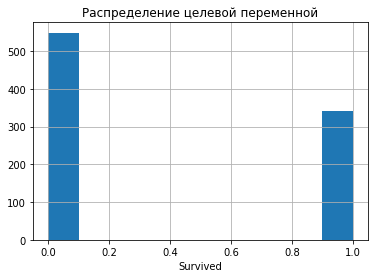

In [15]:
# Посмотрим на распределение целевой переменной
df_titanic.Survived.hist()
plt.xlabel("Survived")
plt.title("Распределение целевой переменной")
count_surv=df_titanic[df_titanic.Survived==1].Survived.count()
count_not_surv=df_titanic[df_titanic.Survived==0].Survived.count()

print(f"Количество выживших пассажиров: {count_surv}")
print(f"Количество невыживших пассажиров: {count_not_surv}")
print(f"Соотношение между группами: {100-min(count_surv,count_not_surv)*100/max(count_surv,count_not_surv)}")

Из диаграммы видно не сбалансированность классов пассажиров.
Погибших почти на 38% больше выжевших.
Это нужно будет учесть при прогнозированнии модели.

Далее попорядку пройдемся по всем признакам. Что бы выявить особенности данных, и подготовить их к обучению.

Признак Pclass
Как следует из описание данный признак класс билета и уже из описания понятно, что данный признак не количественный, а представлен градациями. При этом так как класс обозначает уровень комфорта, с которым путешествовал пассажир, понятно что градации упорядочены, т.е. можно прослеить отношения между градациями 

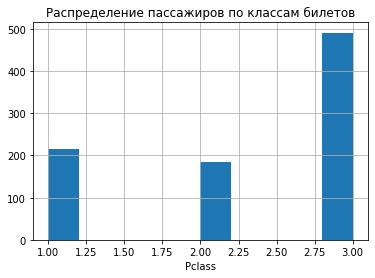

In [16]:
# Начнем с построения диаграммы распределения всех пассажиров по классам
df_titanic.Pclass.hist()
plt.xlabel("Pclass")
plt.title("Распределение пассажиров по классам билетов")
plt.show()

Как и следовало ожидать большая часть пассажиров путешествовало 3-им классом.
Посмотри на это же распределение, только при учете целевой переменной.



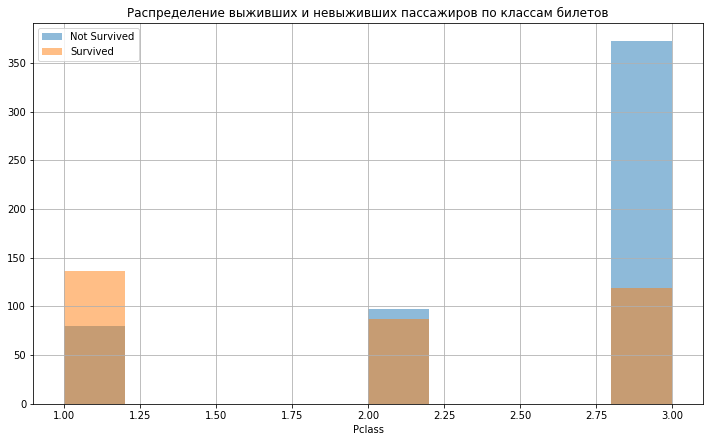

In [17]:
plt.figure(figsize=(12,7))
df_titanic.groupby("Survived").Pclass.hist(alpha=0.5)
plt.title("Распределение выживших и невыживших пассажиров по классам билетов")
plt.xlabel("Pclass")
plt.legend(["Not Survived","Survived"])
plt.show()

Как и следовало ожидать большая часть пассажиров первого класса выжила. Количество выживших и погибших пассажиров 2 класса примерно равно и большая часть пассажиров 3 класса погибло. Это не удивительно 1 класс находился наверхних палубах, до шлюпок им было добраться легче всего. 
Как было показано выше данный признак известен для всех пассажиров, кроме того изначально это числовой признак, при этом числа отображают отношения между пассажирами разных классов (1<2<3 - что отражает количество погибших пассажиров.)

Признак Name
Текстовый признак является именем пассажира. При этом известны имена всех пассажиров.


In [18]:
df_titanic.Name

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

В именах пассажиров есть обращение к их статусу можно попробовать преобразовать этот признак и получить статус пассажира (вежливое обращение к нему) в обществе.
Однако есть подозрение, что в известном наборе приведено не все возможное множество обращений и вилика вероятность в будущем для предсказания столкнуться с неизвестным титулом и др. По этому пока предлагается полностью проигнорировать признак имя.

Признак Sex
Пол пассажира
Данный признак бинарный и также известен для всех пассажиров
Посмотрим на распределение этого признака среди всех пассажиров


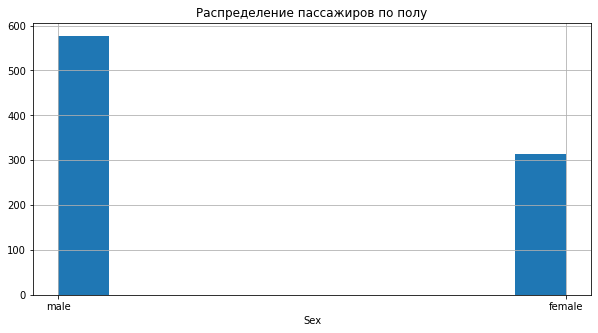

In [19]:
plt.figure(figsize=(10,5))
df_titanic.Sex.hist()
plt.title("Распределение пассажиров по полу")
plt.xlabel("Sex")
plt.show()

Из графика видно, что количество мужчин почти в два раза превышает количество женщин на борту Титаника

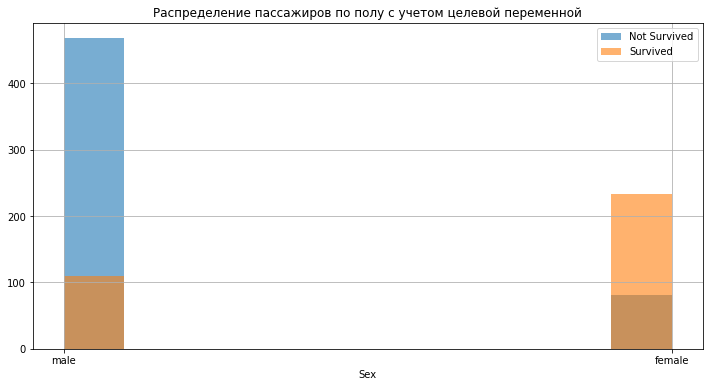

In [20]:
plt.figure(figsize=(12,6))
df_titanic.groupby("Survived").Sex.hist(alpha=0.6)
plt.title("Распределение пассажиров по полу с учетом целевой переменной")
plt.xlabel("Sex")
plt.legend(["Not Survived", "Survived"])
plt.show()

На данной диаграме можно увидеть, что хоть всех женщин на Титанике было почти в 2 раза меньше, выжило в итоги из нихв два раза больше.

Признак Age

Посмотрим на распределение возрастаё

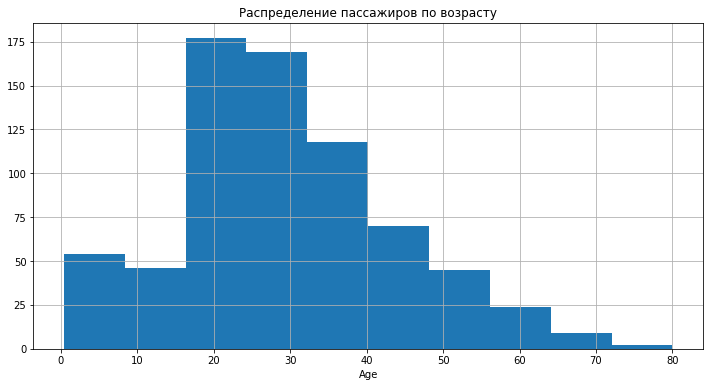

In [21]:
plt.figure(figsize = (12,6))
df_titanic.Age.hist()
plt.xlabel("Age")
plt.title("Распределение пассажиров по возрасту")
plt.show()

Теперь распределение с учетом целевой переменной

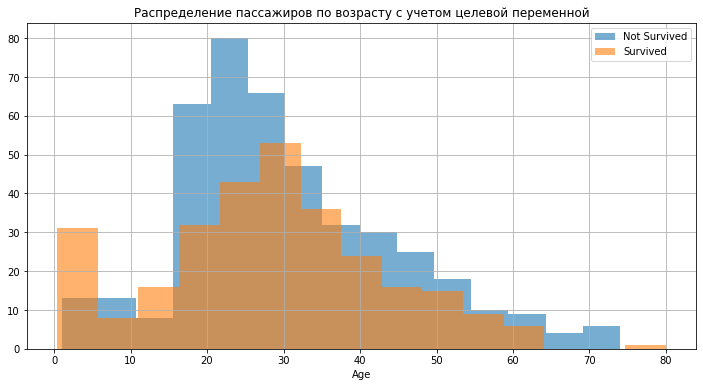

In [22]:
plt.figure(figsize = (12,6))
df_titanic.groupby("Survived").Age.hist(bins=15,alpha=0.6)
plt.xlabel("Age")
plt.title("Распределение пассажиров по возрасту с учетом целевой переменной")
plt.legend(["Not Survived","Survived"])
plt.show()

Также можно построить Boxplot для оценки квантильного размаха

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


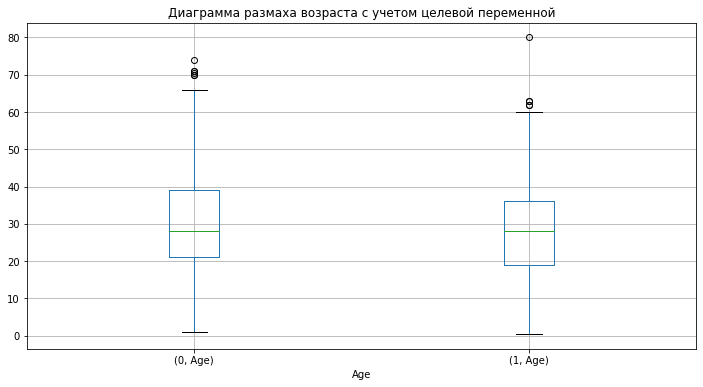

In [23]:
plt.figure(figsize = (12,6))
df_titanic.groupby("Survived").boxplot(subplots=False,column="Age")
plt.xlabel("Age")
plt.title("Диаграмма размаха возраста с учетом целевой переменной")

plt.show()

Кроме того можно посмотреть на распределением еще и с учетом пола

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


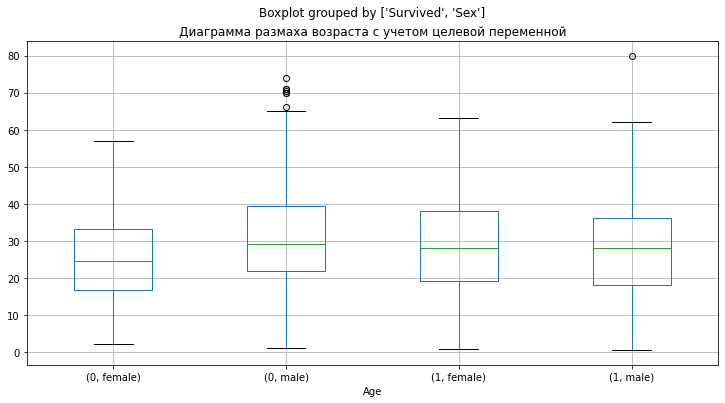

In [24]:
df_titanic.boxplot(column="Age", by=["Survived","Sex"], figsize=(12,6))
plt.xlabel("Age")
plt.title("Диаграмма размаха возраста с учетом целевой переменной")
plt.show()
pass

Из графиков видно, что медианное значение всех 4 груп близко, однако в данных много пропуска и хотелось бы заполнить каждый по наиболее точно.
Попробуем сравнить распределения всех 4 групп между собой. 
Проверим гиотезу H0 - все данные из одного распределения против двусторонней альтернативы.
Для начала проверим данные на нормальность, чтоб понять можем ли мы использовать параметрический метод или стоит использовать непараметрические методы.

In [25]:
famele_not_surv=df_titanic[(df_titanic.Survived==0)&(df_titanic.Sex=="female")&(df_titanic.Age.notnull())].Age.values
mele_not_surv=df_titanic[(df_titanic.Survived==0)&(df_titanic.Sex=="male")&(df_titanic.Age.notnull())].Age.values
famele_surv=df_titanic[(df_titanic.Survived==1)&(df_titanic.Sex=="female")&(df_titanic.Age.notnull())].Age.values
mele_surv=df_titanic[(df_titanic.Survived==1)&(df_titanic.Sex=="male")&(df_titanic.Age.notnull())].Age.values
print(cp.shapiro(famele_not_surv))
print(cp.shapiro(mele_not_surv))
print(cp.shapiro(famele_surv))
print(cp.shapiro(mele_surv))


(0.9739143252372742, 0.1927875429391861)
(0.959311306476593, 1.9239857707020747e-08)
(0.9827942252159119, 0.01629599742591381)
(0.9621220827102661, 0.00852071214467287)


Так как одна выборка не прошла проверку на нормальность будем исользовать U-критерий Мана-Уитни

In [26]:
# Согласно данному критерию мы не можем отвергнуть нулевую гипотезу.
print(f"{cp.mannwhitneyu(famele_not_surv,mele_not_surv)[1]}, порог {0.05/6}")
print(f"{cp.mannwhitneyu(famele_not_surv,famele_surv)[1]}, порог {0.05/6}")
print(f"{cp.mannwhitneyu(famele_not_surv,mele_surv)[1]}, порог {0.05/6}")
print(f"{cp.mannwhitneyu(mele_not_surv,famele_surv)[1]}, порог {0.05/6}")
print(f"{cp.mannwhitneyu(mele_not_surv,mele_surv)[1]}, порог {0.05/6}")
print(f"{cp.mannwhitneyu(famele_surv,mele_surv)[1]}, порог {0.05/6}")

0.0009366670112691589, порог 0.008333333333333333
0.037229508460645495, порог 0.008333333333333333
0.1475403755785657, порог 0.008333333333333333
0.041130584613174266, порог 0.008333333333333333
0.04807113100236761, порог 0.008333333333333333
0.2983933929112257, порог 0.008333333333333333


Лишь в одном случае из всех алгоритм показывает статистическое различие распределений.
Это различия между невыжившими мужчинами и женщинами. 

In [27]:
# Если проверить критерием только выборку по возрасту по целевой переменной
# то достаточно уверенно принемается 0 гипотеза
not_surv=df_titanic[(df_titanic.Survived==0)&(df_titanic.Age.notnull())].Age.values
surv=df_titanic[(df_titanic.Survived==1)&(df_titanic.Age.notnull())].Age.values
print(f"{cp.mannwhitneyu(not_surv,surv)[1]}, порог {0.05}")


0.08024626238868882, порог 0.05


Изходя из проведенного анализа предлагается заполнить все пропуски медианным значением

Тогда примем решение заполнить все строки медианным значением возраста по всей выборке

In [28]:
df_titanic.Age=df_titanic.Age.fillna(df_titanic.Age.median())

Попробуем снова посмотреть на распределение возрастов в двух разных группах


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


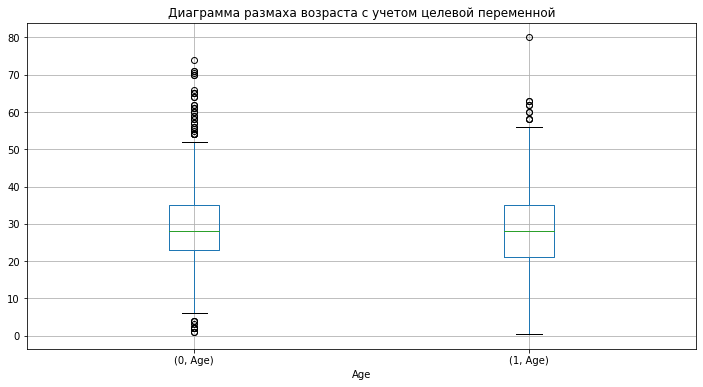

In [29]:
plt.figure(figsize = (12,6))
df_titanic.groupby("Survived").boxplot(subplots=False,column="Age")
plt.xlabel("Age")
plt.title("Диаграмма размаха возраста с учетом целевой переменной")

plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


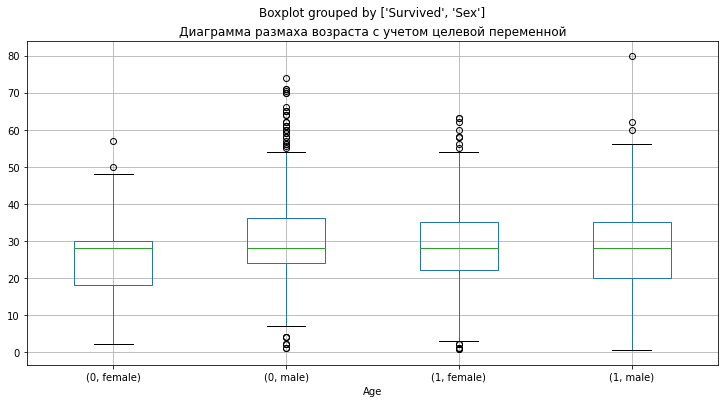

In [30]:
df_titanic.boxplot(column="Age", by=["Survived","Sex"], figsize=(12,6))
plt.xlabel("Age")
plt.title("Диаграмма размаха возраста с учетом целевой переменной")
plt.show()
pass

Видно что график изменил свой вид, медианные значения стали равны и появилось много выбросов. Возмодно решение заменить все значния на медианные было не самым удачным. но вернемся к этому после оценки качества построенной модели если оно нас не устроит.

Для сглаживания этих выбросов и внесенных нами изменений, моно воспользоваться другим приемом. Для этого заменим реальный возраст пассажиров возрастной группой.

Возьмем за основу классификацию по всемирной организации по здравоохранению:
1. [0-17] - Дети 
2. [18-44] - Молодые
3. [45-59] - Средний возраст
4. [60-74] - Пожилой возраст
5. [75-90+] - Старческий возраст


In [31]:
def get_age_group(age):
    """Функция возвращает группу возраста 
    на основе возраста пассажира"""
    if age>=0 and age<=17: return 1
    elif age>=18 and age<=44: return 2
    elif age>=45 and age<=59: return 3
    elif age>=60 and age<=74: return 4
    elif age>=75:return 5


In [32]:
df_titanic["Age_group"] = df_titanic.Age.apply(get_age_group)

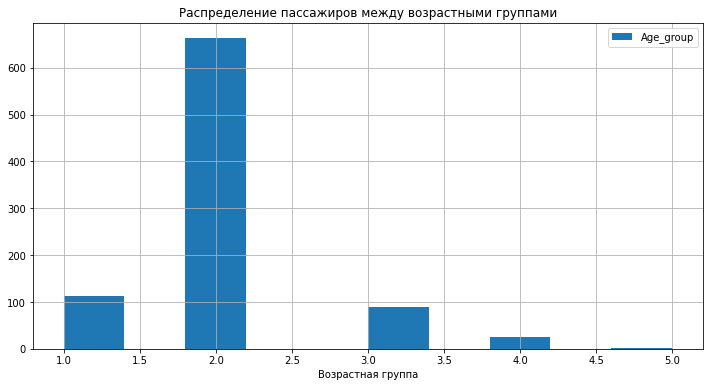

In [33]:
# Взглянем что получилось
plt.figure(figsize = (12,6))
df_titanic["Age_group"].hist(legend="Age_group")
plt.title("Распределение пассажиров между возрастными группами")
plt.xlabel("Возрастная группа")
plt.show()

Получили группы на основе возраста. Посмотрим как распределены выжевшие и невыжевшие пассажиры по этим группам.

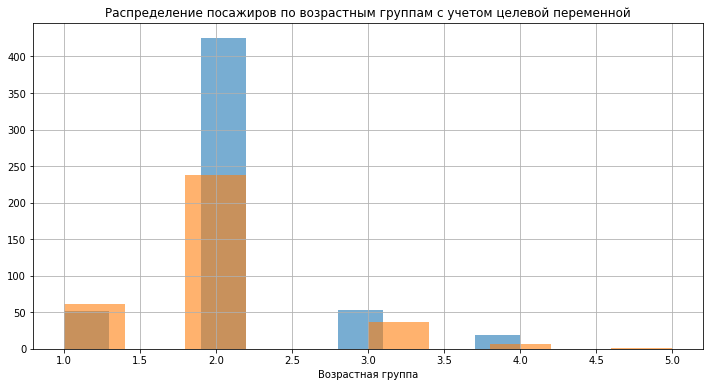

In [34]:
plt.figure(figsize = (12,6))
df_titanic.groupby("Survived").Age_group.hist(alpha=0.6)
plt.title("Распределение посажиров по возрастным группам с учетом целевой переменной")
plt.xlabel("Возрастная группа")
plt.show()

Признак SibSp
Из описания известно, что данный признак количественный.
Посмотрим его распределение и соотношение с учетом целевой переменной

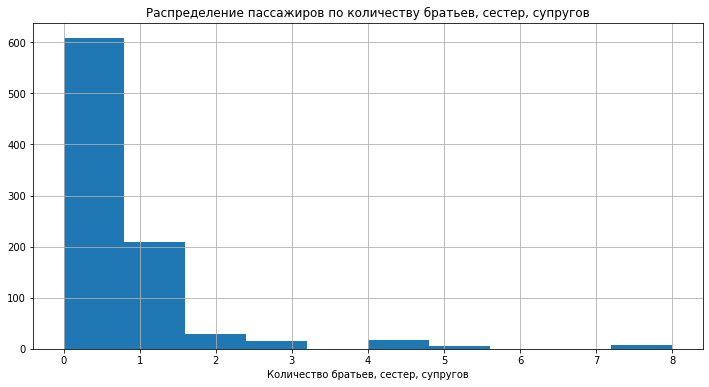

In [35]:
plt.figure(figsize = (12,6))
df_titanic.SibSp.hist()
plt.title("Распределение пассажиров по количеству братьев, сестер, супругов")
plt.xlabel("Количество братьев, сестер, супругов")
plt.show()


Видно что распределение сильно скошено, и большенство людей ехало либо в одиночку либо с одним из перечисленных родственников.

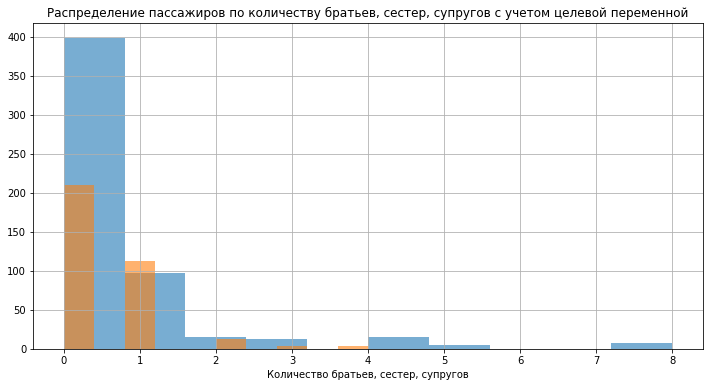

In [36]:
plt.figure(figsize = (12,6))
df_titanic.groupby("Survived").SibSp.hist(alpha=0.6)
plt.title("Распределение пассажиров по количеству братьев, сестер, супругов с учетом целевой переменной")
plt.xlabel("Количество братьев, сестер, супругов")
plt.show()

Видно, что среди выжившие пассажиров имевшие 1-2 указанных родственников сопостовимы с количеством погибших.
Для остальных число погибших намного больше.

Признак Parch
Этот признак по своей сути похож немного на предыдущий, однако он берет другую групппу родственников, связанных друг сдругом дольшей ответственностью.

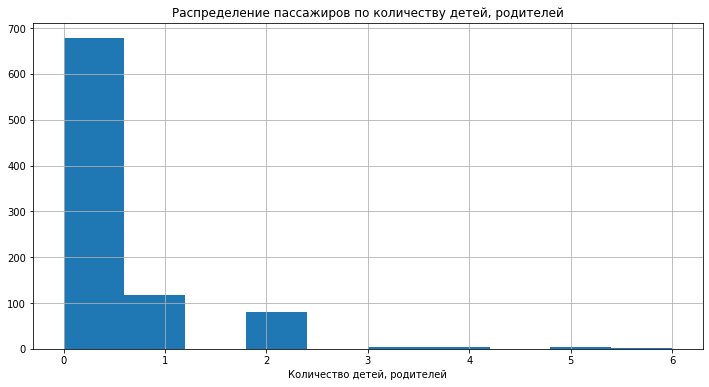

In [37]:
plt.figure(figsize = (12,6))
df_titanic.Parch.hist()
plt.title("Распределение пассажиров по количеству детей, родителей")
plt.xlabel("Количество детей, родителей")
plt.show()


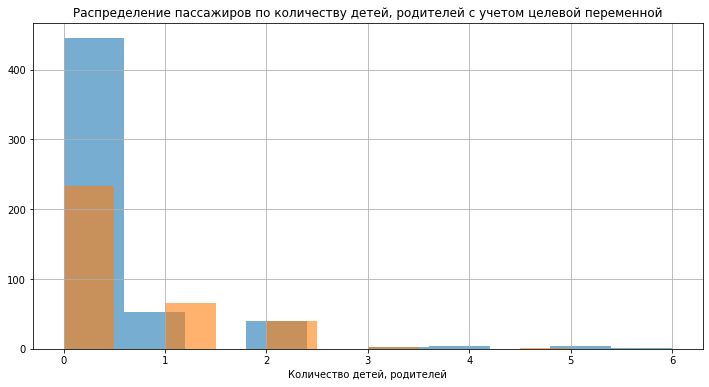

In [38]:
plt.figure(figsize = (12,6))
df_titanic.groupby("Survived").Parch.hist(alpha=0.6)
plt.title("Распределение пассажиров по количеству детей, родителей с учетом целевой переменной")
plt.xlabel("Количество детей, родителей")
plt.show()

Как можно увидеть распределение данного признака похоже на распределение предыдущего, более того кажется, что они характеризуют общее количество родственников. Попробуем заменить эти два признака на один общий равный сумме признаков.

Признак Ticked
Номер билета, сложно сходу представить как использовать этот признак.
Посмотрим есть ли одинаковые номера билетов, и если есть то кому они пренадлежат.

In [39]:
df_titanic.Ticket.value_counts()[df_titanic.Ticket.value_counts()>=5]

347082          7
CA. 2343        7
1601            7
3101295         6
CA 2144         6
347088          6
S.O.C. 14879    5
382652          5
Name: Ticket, dtype: int64

In [40]:
df_titanic[df_titanic.Ticket=="347082"]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_group
PassengerId,,,,,,,,,,,,
14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S,2
120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S,1
542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S,1
543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S,1
611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S,2
814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S,1
851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S,1


In [41]:
df_titanic[df_titanic.Ticket=="S.O.C. 14879"]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_group
PassengerId,,,,,,,,,,,,
73,0,2,"Hood, Mr. Ambrose Jr",male,21.0,0,0,S.O.C. 14879,73.5,NaN,S,2
121,0,2,"Hickman, Mr. Stanley George",male,21.0,2,0,S.O.C. 14879,73.5,NaN,S,2
386,0,2,"Davies, Mr. Charles Henry",male,18.0,0,0,S.O.C. 14879,73.5,NaN,S,2
656,0,2,"Hickman, Mr. Leonard Mark",male,24.0,2,0,S.O.C. 14879,73.5,NaN,S,2
666,0,2,"Hickman, Mr. Lewis",male,32.0,2,0,S.O.C. 14879,73.5,NaN,S,2


Как видно из двух примеров выше одинаковый номер имеют пассажиры, являющиеся либо членами одной семьи либо (на мой взгляд) членами одной организации, этак или иначе трудно представить структурированное применение данному признаку. Будем удалять признак.

Признак Fare
Показывает стоимость билетов. Так как все номера билетов известны то пропусков в этом признаке нет.
Посмотрим на его распределение и диаграммы размаха.

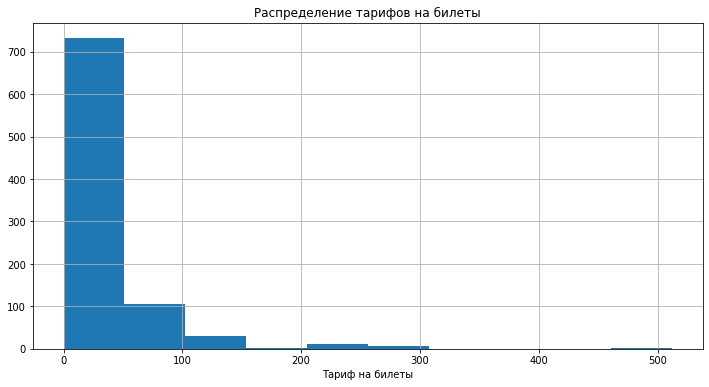

In [42]:
plt.figure(figsize = (12,6))
df_titanic.Fare.hist()
plt.title("Распределение тарифов на билеты")
plt.xlabel("Тариф на билеты")
plt.show()

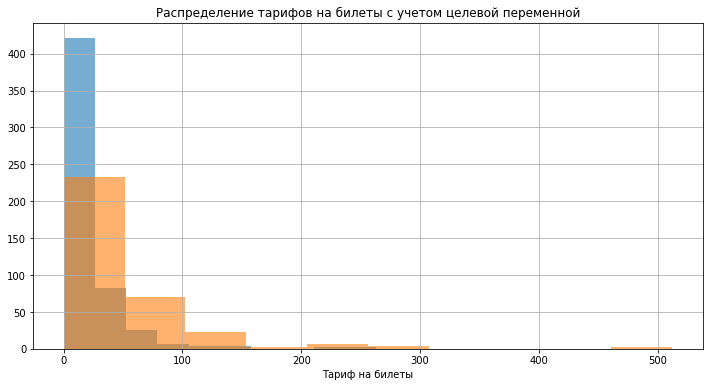

In [43]:
plt.figure(figsize = (12,6))
df_titanic.groupby("Survived").Fare.hist(alpha=0.6)
plt.title("Распределение тарифов на билеты с учетом целевой переменной")
plt.xlabel("Тариф на билеты")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


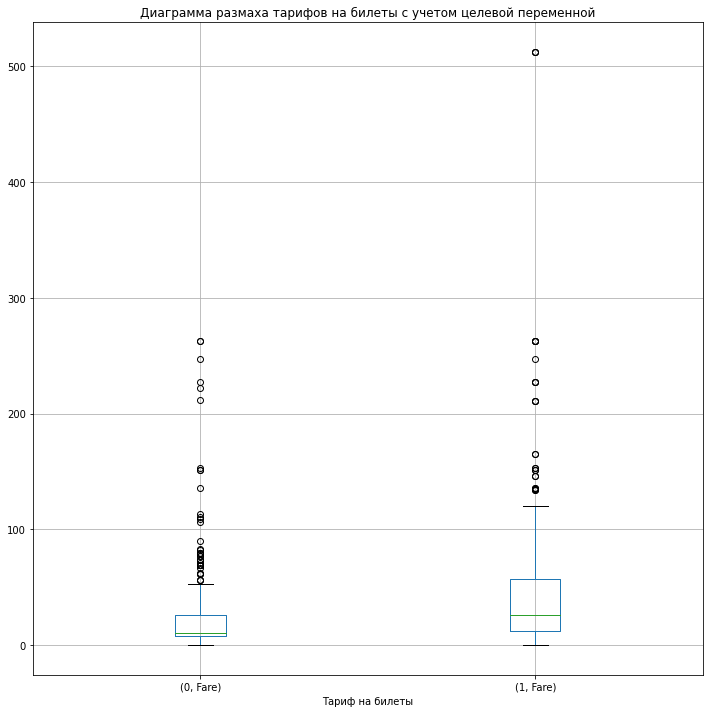

In [44]:
plt.figure(figsize = (12,12))
df_titanic.groupby("Survived").boxplot(subplots=False,column="Fare")
plt.xlabel("Тариф на билеты")
plt.title("Диаграмма размаха тарифов на билеты с учетом целевой переменной")

plt.show()

Видно, что средняя цена билетов для выжевших значительно выше как и максимальная. Что бы убедится что данные принадлежать разным распределениям и сказать, что цена на билет влияет на вероятность выживания применим U-критерий 

In [45]:
cp.mannwhitneyu(df_titanic[df_titanic.Survived==0].Fare,df_titanic[df_titanic.Survived==1].Fare,alternative="less")

MannwhitneyuResult(statistic=57806.5, pvalue=2.2767385896251186e-22)

U-критерий уверенно отвергает нулевую гипотизу, показывая, что чем выше стоимость билета тем вероятность выжитьвыше

Признак Cabin
Признак содержит более больше 50% пропусков, так что не будем пока использовать

Признак Embarked
Как отмечалось ранее номинальный признак. Посмотрим также на его распределение.

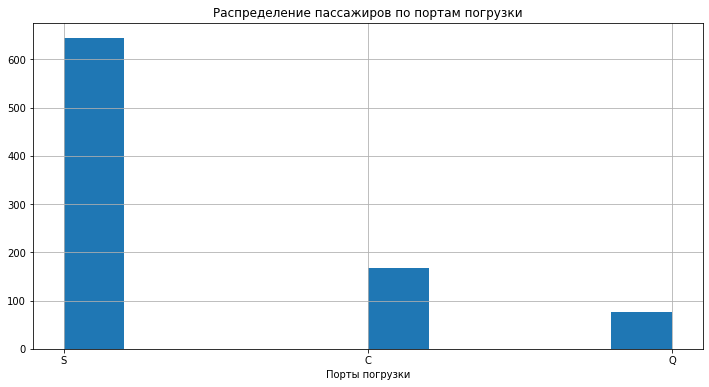

In [46]:
plt.figure(figsize = (12,6))
df_titanic.Embarked.hist()
plt.title("Распределение пассажиров по портам погрузки")
plt.xlabel("Порты погрузки")
plt.show()

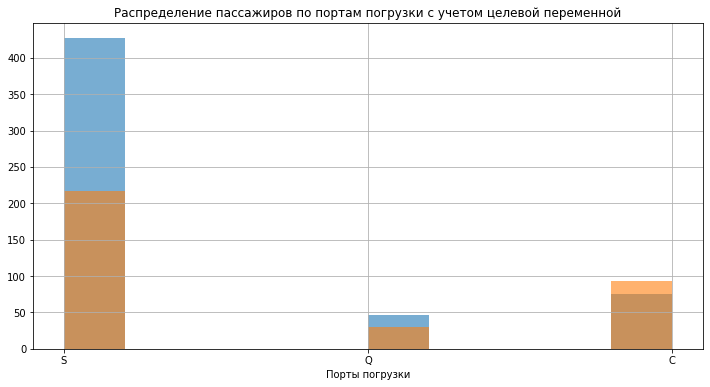

In [47]:
plt.figure(figsize = (12,6))
df_titanic.groupby("Survived").Embarked.hist(alpha=0.6)
plt.title("Распределение пассажиров по портам погрузки с учетом целевой переменной")
plt.xlabel("Порты погрузки")
plt.show()

Видно что данный признак, также оказывает влияния на шанс выживания.
Также признак имел 2 пропущеных значения. Посмотрим на них.

In [48]:
df_titanic[df_titanic.Embarked.isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_group
PassengerId,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,2
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,4


Происследовав разные сочитания понял что онозначно предположить какой был порт назначения у этих пассажиров не представляется возможным. Будем удалять эти строки.


## Предобработка данных

In [49]:
# Еще раз выведем все признаки и их типы

In [50]:
df_titanic.dtypes

Survived       int64
Pclass         int64
Name          object
Sex           object
Age          float64
SibSp          int64
Parch          int64
Ticket        object
Fare         float64
Cabin         object
Embarked      object
Age_group      int64
dtype: object

1. Признак Pclass - оставим без изменения, он нас пока устраивает.
2. Признаки Name, Ticket, Cabin - пока удаляем.
3. Признак Sex - представляем двух бинарных столбцов male, famale.
4. Признак Age - нужно нормализовать (большая часть моделей лучше работают с нормализованными данными)
5. Признак SibSp и Parch - суммируем и получаем новый признак family, обозначающий общее число членов семьи
6. Признак Fare - нужно нормализовать
7 .Признак Embarked - нужно закодировать двоичным вектором



In [51]:
# Для некоторых преобразований потребуются дополнительные библиотеки
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [52]:
# Создадим копию данных
df = df_titanic.copy()
sex = df[["Sex"]]
train_sex = OneHotEncoder(handle_unknown="ignore")
sex = train_sex.fit_transform(sex).toarray()

df["female"] = sex[:,0]
df["male"] = sex[:,1]
#пока не будем нормализовывать Age и Fare, что бы при разбиении на train и test,
# test не участвовал в обучении нормализации
df["family"] = df.SibSp+df.Parch
train_embarked = OneHotEncoder(handle_unknown="ignore")
# Удалим из Embarked пустые значение
df=df[df["Embarked"].notna()]
embarked = df[["Embarked"]]
embarked = train_embarked.fit_transform(embarked).toarray()
df["C"]=embarked[:,0]
df["Q"]=embarked[:,1]
df["S"]=embarked[:,2]
# Удаляем лишние столбцы
df = df.drop(["Name","Sex","Ticket","Cabin","Embarked","SibSp","Parch"], axis=1)
# Так же можно удалить пассажира с возрастом 80, посчитав это сильным выбрасом, 
# так как и в правду он его возраст сильно отличается от основного распределения
df = df[df.Age<80]
df

,Survived,Pclass,Age,Fare,Age_group,female,male,family,C,Q,S
PassengerId,,,,,,,,,,,
1,0,3,22.0,7.2500,2,0.0,1.0,1,0.0,0.0,1.0
2,1,1,38.0,71.2833,2,1.0,0.0,1,1.0,0.0,0.0
3,1,3,26.0,7.9250,2,1.0,0.0,0,0.0,0.0,1.0
4,1,1,35.0,53.1000,2,1.0,0.0,1,0.0,0.0,1.0
5,0,3,35.0,8.0500,2,0.0,1.0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,27.0,13.0000,2,0.0,1.0,0,0.0,0.0,1.0
888,1,1,19.0,30.0000,2,1.0,0.0,0,0.0,0.0,1.0
889,0,3,28.0,23.4500,2,1.0,0.0,3,0.0,0.0,1.0


Теперь когда данные почти полностью подготовленны можно оценить их взаимное влияние друг на друга без учета целевой переменной

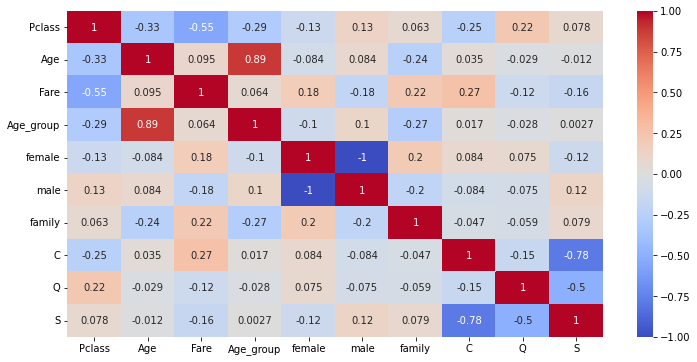

In [53]:
# Корреляция Пирсона
plt.figure(figsize=(12,6))
sns.heatmap(df.drop("Survived",axis=1).corr(),annot=True,cmap="coolwarm")
plt.show()


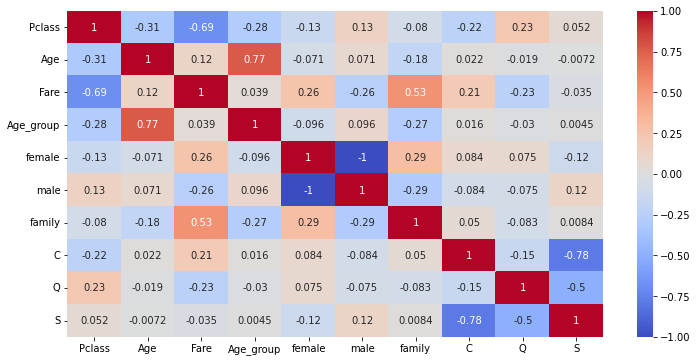

In [54]:
# Корреляция Спирмана
plt.figure(figsize=(12,6))
sns.heatmap(df.drop("Survived",axis=1).corr(method="spearman"),annot=True,cmap="coolwarm")
plt.show()

Как видно из матриц корреляции достаточно сильно коррелируют признаци Age и Age_group, 
что очевидно, так как это практически один признак. А также female и male, так как 
представляют из себя два возможных значения признака Sex.
Так же видна корреляция между признаками Fare и Pclass, а также портами погрузки C и S.
Эту взаимосвязь можно проверить статистически.


In [55]:
# Критерий Пирсона показывает, что коррелция есть но она статистически не значима
print(f"p-value: {cp.pearsonr(df.Fare,df.Pclass)[1]}")
print(f"p-value: {cp.pearsonr(df.C,df.S)[1]}")    

p-value: 4.6806483981942626e-71
p-value: 1.5766837804485966e-184


In [56]:
# Критерий Спирмана показывает, что коррелция есть но она статистически не значима
print(f"p-value: {cp.spearmanr(df.Fare,df.Pclass)[1]}")
print(f"p-value: {cp.spearmanr(df.C,df.S)[1]}")    

p-value: 2.2917794199157134e-124
p-value: 1.5766837804486797e-184


Посмотрим теперь как признаками разделяются пассажиры на выжевших и нет

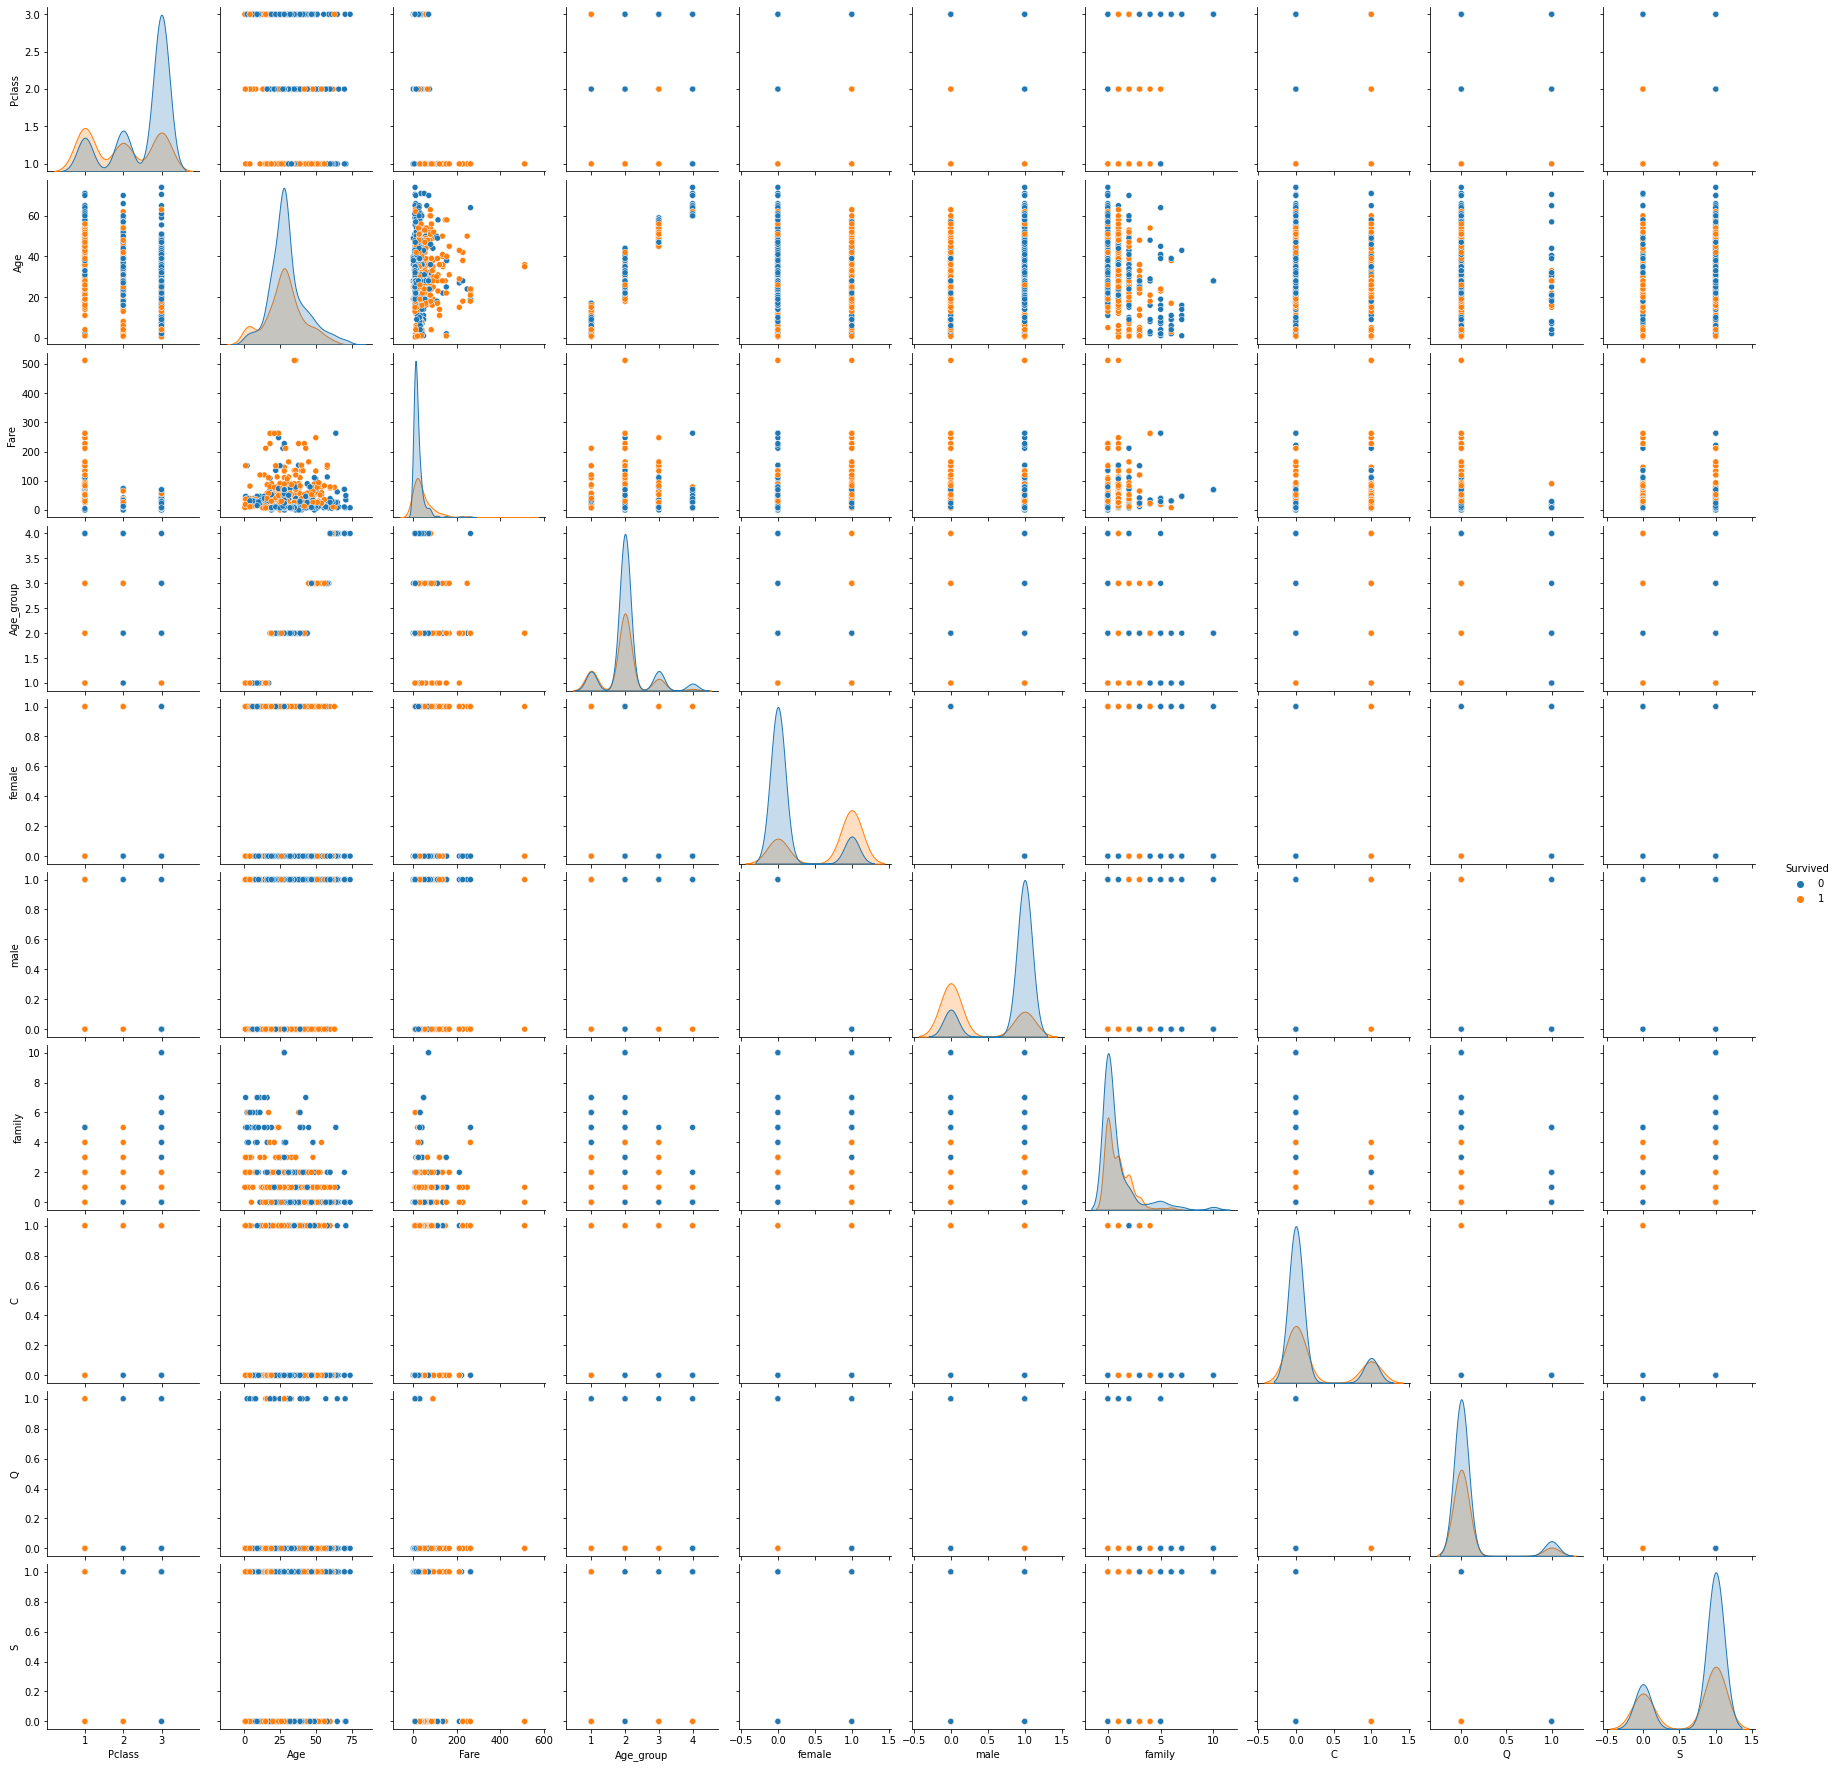

In [57]:
sns.pairplot(df,hue="Survived")


После построение данного графика, можно лучше оценить зависимоть целевой переменной от признаков, видно что некоторые признаки не плохо разделяют пассажиров, такие как порт Q, male. Есть ощущение, что в совокупности мы можем получить хороший результат.

Осталось разбить модель на train и test, донастроить оставшиеся признаки и приступить к настройке подели.

In [58]:
from sklearn.model_selection import cross_val_score, train_test_split

Разобьем данные на обучение и валидацию. Установим начальное значение генератора для воспроизводимости результатов.

In [59]:
df_train = df.drop(["Age_group"],axis=1)
X = df_train.drop(["Survived"],axis=1)
y = df_train["Survived"]
np.random.seed(11)

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.1, stratify=y,shuffle=True)
train_fare = StandardScaler()
train_age = StandardScaler()
train_family = StandardScaler()
X_train.Fare = train_fare.fit_transform(X_train[["Fare"]])
X_train.Age = train_age.fit_transform(X_train[["Age"]])
X_train.family = train_family.fit_transform(X_train[["family"]])
X_val.Fare = train_fare.transform(X_val[["Fare"]])
X_val.Age = train_age.transform(X_val[["Age"]])
X_val.family = train_family.transform(X_val[["family"]])
X_train

,Pclass,Age,Fare,female,male,family,C,Q,S
PassengerId,,,,,,,,,
44,2,-2.040079,0.181827,1.0,0.0,1.252839,1.0,0.0,0.0
167,1,-0.094921,0.448822,1.0,0.0,0.040218,0.0,0.0,1.0
614,3,-0.094921,-0.491175,0.0,1.0,-0.566092,0.0,1.0,0.0
362,2,-0.017114,-0.093874,0.0,1.0,0.040218,1.0,0.0,0.0
820,3,-1.495435,-0.090309,0.0,1.0,2.465461,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
424,3,-0.094921,-0.358880,1.0,0.0,0.646529,0.0,0.0,1.0
26,3,0.683143,-0.020928,1.0,0.0,3.071771,0.0,0.0,1.0
55,1,2.783914,0.587667,0.0,1.0,0.040218,1.0,0.0,0.0


Предобработка завершена можно переходить к построению моделей

## Построение модели

Рассмотрим 3 основных вида модели для данной задачи:
1. Логистическая регрессия
2. Случайный лес
3. Градиентный бустинг

In [60]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [61]:
def fit_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_val)
    print(f"accuracy: {accuracy_score(y_val, y_predict)}")
    print(f"roc_auc: {roc_auc_score(y_val, y_predict)}")
    print(classification_report(y_val,y_predict))

In [62]:
np.random.seed(11)
# Простая Логистическая рекрессия
model_LR = LogisticRegression()
# Логистическая регрессия с разными весами, так каккласы не сбалансированны
model_LR_weight = LogisticRegression(class_weight={0:1,1:2.4})
fit_model(model_LR, X_train, y_train, X_val, y_val)
fit_model(model_LR_weight, X_train, y_train, X_val, y_val)

accuracy: 0.7640449438202247
roc_auc: 0.7192513368983956
              precision    recall  f1-score   support

           0       0.76      0.91      0.83        55
           1       0.78      0.53      0.63        34

    accuracy                           0.76        89
   macro avg       0.77      0.72      0.73        89
weighted avg       0.77      0.76      0.75        89

accuracy: 0.7865168539325843
roc_auc: 0.7655080213903743
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        55
           1       0.74      0.68      0.71        34

    accuracy                           0.79        89
   macro avg       0.78      0.77      0.77        89
weighted avg       0.78      0.79      0.78        89



In [63]:
np.random.seed(11)
model_RF = RandomForestClassifier()
model_RF_f = RandomForestClassifier(n_estimators=90,n_jobs=-1, min_samples_leaf=3, max_features="sqrt")
fit_model(model_RF, X_train, y_train, X_val, y_val)
fit_model(model_RF_f, X_train, y_train, X_val, y_val)

accuracy: 0.7752808988764045
roc_auc: 0.7620320855614974
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        55
           1       0.71      0.71      0.71        34

    accuracy                           0.78        89
   macro avg       0.76      0.76      0.76        89
weighted avg       0.78      0.78      0.78        89

accuracy: 0.8202247191011236
roc_auc: 0.7871657754010695
              precision    recall  f1-score   support

           0       0.81      0.93      0.86        55
           1       0.85      0.65      0.73        34

    accuracy                           0.82        89
   macro avg       0.83      0.79      0.80        89
weighted avg       0.82      0.82      0.81        89



In [64]:
np.random.seed(11)
model_GB = GradientBoostingClassifier()
model_GB_f = GradientBoostingClassifier(n_estimators=1000,learning_rate=0.05, min_samples_leaf=4)
fit_model(model_GB, X_train, y_train, X_val, y_val)
fit_model(model_GB_f, X_train, y_train, X_val, y_val)

accuracy: 0.8089887640449438
roc_auc: 0.7780748663101604
              precision    recall  f1-score   support

           0       0.81      0.91      0.85        55
           1       0.81      0.65      0.72        34

    accuracy                           0.81        89
   macro avg       0.81      0.78      0.79        89
weighted avg       0.81      0.81      0.80        89

accuracy: 0.8426966292134831
roc_auc: 0.822192513368984
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        55
           1       0.83      0.74      0.78        34

    accuracy                           0.84        89
   macro avg       0.84      0.82      0.83        89
weighted avg       0.84      0.84      0.84        89



## Выводы

1. Были рассмотрен датасет пассажиров Титаника.
2. Осуществлен разбор данных, и их изучение.
3. Изучена взаимосвязь исходных данных и целевой переменной.
4. Данные преобразованны в формат для большего качества и удобства работы с моделями.
5. Построены 3 основные модели классификации данных (каждая в режиме из коропки и с настроенными параметрами)
6. С получеными данными модели из коробки работают примерно одинаково, но градиентный бустинг немного выделяется.
7. Настроенные ансамбли справляются с задачей лучше простой логистической регрессии.
8. Были получены модели с приемлимым качеством решения поставленной задачи.


### Дальнейшее направление для улучшения качества моделей

1. Попробовать скорректировать входные данные.
2. Попробовать вместо возраста использовать возрастную группу.
3. Исключить признаки даже статистически незначимо коррелирующие друг с другом.
4. Попробовать заменить пропущенные значения возраста на среднее, на среднее по полу.
5. Разобрать поля Cabin, Name, Ticket, с целью выяснения пригодных для анализа и работы моделей данных.
6. Попробовать перекодировать признак Pclass, чтобы числовые данные лучше отражали разницу в классе.
7. Провести кроссвалидацию моделей.
8. Более тонко подобрать гипер-параметры.
9. Построить графики обучения моделей.
10. Изучить пороги переобучения.
11. За счет всего выше перечисленного по возможности получить лучшее качество на моделях.
